In [34]:
from data_sim_module import plot_pca_fi, get_curve_samples, multi_partite_distance, get_questionnaires, \
                            get_true_mds, compute_mds, align_pca_mds, corr_between_coords, get_pca, \
                            get_t_sne, get_ans_dict

import pandas as pd
import numpy as np
import scipy.stats
import pickle

from scipy.spatial.distance import hamming

from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score
from sklearn import cluster

from itertools import product

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size" : 15, 
                     "figure.dpi" : 100, 
                     "legend.fontsize" : 13, 
                     "grid.alpha" : 0.3,
                     "axes.grid": True, 
                     "axes.axisbelow" : True, 
                     "figure.figsize":(6, 5)})

import sys
sys.path.append("../../../data/")

In [11]:
filepath = "../../BCCASII/Household/top_features_handpicked.xlsx"

# load data file and variable types
DATA = pd.read_excel(filepath)

In [12]:
def weighted_hamming(X):
    # compute number of categories per feature
    pi_k = np.zeros(len(X.columns))
    for i, col in enumerate(X.columns):
        pi_k[i] = len(X[col].unique())
    pi_k = 1/pi_k

    X = np.array(X)

    H = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            hamming = np.sum(np.array(X[i] != X[j]) * pi_k)
            H[i][j] = hamming
            H[j][i] = hamming
            
    return H

In [13]:
def get_embedding(DATA, algorithm, d):
    X = DATA
    if algorithm == "tsne":
        embeddings = tsne_parameter_sweep(X, d=d)
        title = "T-SNE"
    elif algorithm == "dmap":
        embeddings = dmap_parameter_sweep(X, d=d)
        title = "Diffusion Maps"
    else:
        print(f"Algorithm '{algorithm}' not implemented.")
        return
    
    best_emb, best_params, best_performance, best_labels = find_best_embedding_no_target(embeddings)
    plot_best_embedding(best_emb, best_labels, title, d)
    
    return (X, best_emb, best_params, best_performance)


def find_best_embedding_no_target(embeddings):
    print("Finding best embedding without target...")
    best_emb = None
    best_params = None
    best_performance = -10
    best_labels = None
    
    for param_comb, embedding in embeddings.items():        
        best_k = None
        best_silhouette = -10
        best_lab = None
        
        for k in range(2, 10):
            labels = cluster.AgglomerativeClustering(n_clusters=k).fit_predict(embedding)
            score = silhouette_score(embedding, labels)
            if score > best_silhouette:
                best_k = k
                best_silhouette = score
                best_lab = labels

        if best_silhouette > best_performance:
            best_performance = best_silhouette
            best_emb = embedding
            best_params = param_comb
            best_labels = best_lab
    
    return best_emb, best_params, best_performance, best_lab


def plot_best_embedding(best_emb, y, title, d):
    
    groups = {}
    for idx, row in enumerate(best_emb):
        label = y[idx]
        if label not in groups:
            groups[label] = [row]
        else:
            groups[label].append(row)
            
    cmap = matplotlib.cm.get_cmap('tab20')
    cidx = 0
    if d == 2:
        for g, rows in groups.items():
            stacked = np.vstack(rows)
            plt.scatter(stacked[:,0], stacked[:,1], s=5, label=g, color=cmap(cidx))
            cidx += 1
    elif d == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        for g, rows in groups.items():
            stacked = np.vstack(rows)
            ax.scatter(stacked[:,0], stacked[:,1], stacked[:,2], s=5, label=g, color=cmap(cidx))
            cidx += 1
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title(title)
    plt.show()

___

# T-SNE

In [14]:
def tsne_parameter_sweep(X, d):
    print("Performing parameter sweep...")
    # parameter grid
    perplexity_values    = [25, 50, 75, 100]
    learning_rate_values = [2, 4, 6, 8]
    metrics              = ["hamming", "hamming 1hot", "cosine 1hot"]
    
    X_one_hot = pd.DataFrame(OneHotEncoder(sparse=False, drop="if_binary").fit_transform(X))
    
    distances = {
        "hamming":      weighted_hamming(X),
        "hamming 1hot": weighted_hamming(X_one_hot),
        "cosine 1hot":  weighted_hamming(X_one_hot)
    }

    parameter_combinations = list(product(perplexity_values, learning_rate_values, metrics))
    tsne_embeddings = {}
    for c_idx, combination in enumerate(parameter_combinations):
        p, lr, m = combination
        tsne_embeddings[(p,lr,m)] = TSNE(n_components=d, perplexity=p, square_distances=True,
                                         learning_rate=lr, metric="precomputed").fit_transform(distances[m])
#         print("[" + "."*(c_idx+1) + " "*(len(parameter_combinations)-1-c_idx) + "]")
    return tsne_embeddings

In [23]:
X, tsne_best_emb, best_params, best_performance = get_embedding(DATA, algorithm="tsne", d=2)

print(f"\nBest silhouette score = {best_performance:.3f}")
print("\nBest parameters:")
print(f"perplexity    = {best_params[0]}")
print(f"learning rate = {best_params[1]}")
print(f"metric        = {best_params[2]}")

___

# Diffusion Maps

In [43]:
# code is adapted from:
# https://github.com/arashbehboodi/DiffusionMap


def diffusionmap(distance_mat, n, eps, t, n_eigen, alpha=1/2):
    """
    distance_mat: distance matrix
    t: t indicates the number of iterations.
    n_eigen: indicates the target dimension for dimensionality reduction
    eps: is the parameter of Guassian kernel that is used.
    """    
    
#     # Finding the distance matrix"
#     covariance_matrix = data_matrix@data_matrix.T

#     distance_mat_1 = -2*covariance_matrix
#     distance_mat_2 = np.outer(np.diag(covariance_matrix), np.ones((n, 1))) + np.outer(np.ones((n, 1)), np.diag(covariance_matrix).T)
#     distance_mat = distance_mat_1+distance_mat_2

    # Kernel function for weight matrx: Gaussian Kernel
    # Constructing the weight matrix
    W = np.exp(-distance_mat/eps)
    
    # Degree matrix
    Deg = W@np.ones((n, 1))
    D = np.diag(Deg.reshape(n,))
    
    # Transition matrix
    M = np.linalg.inv(D)@W
    
    # Constructing the matrix S - obtaining diffusion vectors
    S = D**(alpha)@M@np.linalg.inv(D)**(alpha)
    
    # Spectral decomposition
    eigvalCov, eigvecCov = np.linalg.eig(S)
    idx = eigvalCov.argsort()[::-1]
    eigvalCov = eigvalCov[idx]
    eigvecCov = eigvecCov[:, idx]
    
    # Diffusion Map
    phiD = np.linalg.inv(D)**(alpha)@eigvecCov
    lambdaD = eigvalCov**t
    
    # Final Matrix with columns as the vectors
    DiffM = np.diag(lambdaD)@phiD.T
    Difftruncated = DiffM[1:n_eigen+1, :]
    return Difftruncated.T

In [44]:
def dmap_parameter_sweep(X, d):
    print("Performing parameter sweep...")
    
    # parameter grid
    epsilon_values = np.linspace(5, 200, 10)
    t_values       = [0, 0.25, 0.5]
    metrics       = ["hamming", "hamming 1hot", "cosine 1hot"]
    
    X_one_hot = pd.DataFrame(OneHotEncoder(sparse=False, drop="if_binary").fit_transform(X))
    
    distances = {
        "hamming":      weighted_hamming(X),
        "hamming 1hot": weighted_hamming(X_one_hot),
        "cosine 1hot":  weighted_hamming(X_one_hot)
    }

    parameter_combinations = list(product(epsilon_values, t_values, metrics))
    dmap_embeddings = {}
    for c_idx, combination in enumerate(parameter_combinations):
        eps, t, m = combination
        dmap_embeddings[(eps, t, m)] = np.real(diffusionmap(distance_mat=distances[m], 
                                                            n=len(X), eps=eps, 
                                                            t=t, n_eigen=d))
    return dmap_embeddings

In [37]:
X, dmap_best_emb, best_params, best_performance = get_embedding(DATA, algorithm="dmap", d=2)

print(f"\nBest (mean) silhouette score = {best_performance:.3f}")
print("\nBest parameters:")
print(f"epsilon = {best_params[0]:.2f}")
print(f"t       = {best_params[1]}")
print(f"metric  = {best_params[2]}")

# No param tuning, t-SNE and DM side by side

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


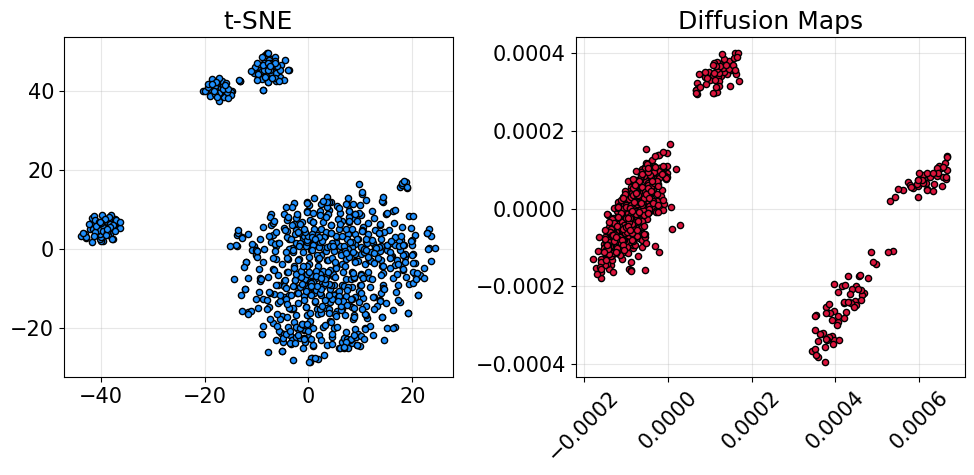

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))


X_one_hot = pd.DataFrame(OneHotEncoder(sparse=False, drop="if_binary").fit_transform(DATA))

ham = weighted_hamming(X_one_hot)
tsne_coords = TSNE(metric="precomputed").fit_transform(ham)
axs[0].scatter(tsne_coords[:,0], tsne_coords[:,1], color="dodgerblue", edgecolor="k", s=20)
axs[0].set_title("t-SNE")

D = cosine_distances(X_one_hot)
dm_coords = diffusionmap(D, len(DATA), 2, 0.5, 2)
axs[1].scatter(dm_coords[:,0], dm_coords[:,1], color="crimson", edgecolor="k", s=20)
axs[1].set_title("Diffusion Maps")
axs[1].tick_params(axis='x', labelrotation = 45)

plt.tight_layout()
plt.savefig("tsne_dm_bccas.pdf", bbox_inches="tight")
plt.show()